In [1]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [2]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, Flatten
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.initializers import Constant
from keras.layers import *

import os
import pandas as pd
import numpy as np
from numpy import array
import re

Using TensorFlow backend.


In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_sentence'])
df = df[df['y_sentence'] < 481]

In [4]:
X = df.drop('y_sentence', axis=1)
y = df['y_sentence']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]


In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = pad_sequences(X3_train, sequence_length)
X3_test = pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = Input(shape=(687,))
input_2 = Input(shape=(663,))

#dense_layer_1_0 = Dense(48, activation='relu')(input_1)
dense_layer_1_1 = Dense(20, activation='relu')(input_1)
dense_layer_1_2 = Dense(10, activation='relu')(dense_layer_1_1)
dropout_1_3 = Dropout(0.2)(dense_layer_1_2)

dense_layer_2_1 = Dense(20, activation='relu')(input_2)
dense_layer_2_2 = Dense(10, activation='relu')(dense_layer_2_1)
dropout_2_3 = Dropout(0.2)(dense_layer_2_2)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

23441


In [10]:
input_3 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_1_3 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)

maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = Flatten()(concatenated_tensor_3)
dropout_3 = Dropout(0.5)(flatten_3)
#dense_layer_3 = Dense(12, activation='relu')(dropout_3)

In [11]:
concat_layer = Concatenate()([dropout_1_3, dropout_2_3, dropout_3])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(1, activation='linear')(dense_layer_3)
model = Model(inputs=[input_1, input_2, input_3], outputs=output)

In [12]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 128)     3000448     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 128, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 1, 100)  38500       reshape_1[0][0]                  
____________________________________________________________________________________________

In [13]:
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=128, epochs=50, 
                   verbose=1, validation_split=0.1)# , callbacks=[early_stopping])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3193 samples, validate on 355 samples
Epoch 1/50
3193/3193 [==============================] - 3s 964us/step - loss: 2101.8580 - mse: 2073.4385 - mae: 20.4238 - mape: 958442496.0000 - cosine: 0.8274 - val_loss: 1496.0230 - val_mse: 1448.2572 - val_mae: 17.9518 - val_mape: 2444481024.0000 - val_cosine: 0.8366
Epoch 2/50
3193/3193 [==============================] - 1s 181us/step - loss: 1695.9084 - mse: 1632.3300 - mae: 21.4544 - mape: 3131840000.0000 - cosine: 0.8569 - val_loss: 1392.2037 - val_mse: 1324.4644 - val_mae: 20.7889 - val_mape: 3806395904.0000 - val_cosine: 0.8366
Epoch 3/50
3193/3193 [==============================] - 1s 176us/step - loss: 1564.9465 - mse: 1496.4701 - mae: 21.1033 - mape: 3311619328.0000 - cosine: 0.8569 - val_loss: 1331.8456 - val_mse: 1260.9531 - val_mae: 20.2824 - val_mape: 3839303424.0000 - val_cosine: 0.8366
Epoch 4/50
3193/3193 [==============================] - 1s 180us/step - loss: 1445.0639 - mse: 1369.0027 - mae: 20.5097 - mape: 3413641728

3193/3193 [==============================] - 1s 176us/step - loss: 281.6259 - mse: 137.9815 - mae: 7.7639 - mape: 1089347200.0000 - cosine: 0.8556 - val_loss: 747.1422 - val_mse: 603.7012 - val_mae: 13.1974 - val_mape: 1749757440.0000 - val_cosine: 0.8366
Epoch 32/50
3193/3193 [==============================] - 1s 180us/step - loss: 275.6070 - mse: 133.9082 - mae: 7.4521 - mape: 1053851456.0000 - cosine: 0.8569 - val_loss: 736.1344 - val_mse: 596.2150 - val_mae: 13.1876 - val_mape: 1754033024.0000 - val_cosine: 0.8366
Epoch 33/50
3193/3193 [==============================] - 1s 179us/step - loss: 272.1465 - mse: 133.4409 - mae: 7.4740 - mape: 1022712000.0000 - cosine: 0.8562 - val_loss: 727.2076 - val_mse: 589.2005 - val_mae: 13.3900 - val_mape: 1949426048.0000 - val_cosine: 0.8366
Epoch 34/50
3193/3193 [==============================] - 1s 177us/step - loss: 265.9296 - mse: 131.2632 - mae: 7.3794 - mape: 1016046656.0000 - cosine: 0.8562 - val_loss: 752.9440 - val_mse: 620.1378 - val_ma

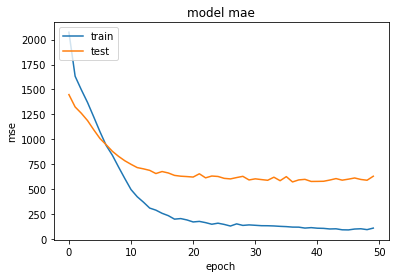

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mae')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)
print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
#print("Test MAE: ", score[2])

395/395 [==============================] - 0s 479us/step
[428.8122890810423, 327.9762878417969, 10.875032424926758, 2137706368.0, 0.8050633072853088]
Test Score: 428.8122890810423
Test MSE: 327.9762878417969
